In [4]:
import pandas as pd
import numpy as np
import os
from skimage.io import imread
from tqdm import tqdm_notebook
from prettytable import PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline

# Exploring and visualizing the data

In [5]:
ship_dir = '/Users/dimasyrovitsky/Documents/Airbus_Ship_Detection_v2/airbus-ship-detection-dataset/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [6]:
#Load the file which contains the masks for each image
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))

In [7]:
masks.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Note: some images appear multiple times in the dataframe, because it contains multiple ships and each ship has a separate mask, located in separate rows.

Total number of masks (full dataset size = ships + images without ships):	 231723
 ↳Number of images without ships (number of empty masks):			 150000
 ↳Total number of ships (number of non-empty masks):				 81723

Number of images:								 192556
 ↳Number of images without ships (number of empty masks):			 150000
 ↳Number of images containing a ship:						 42556
   ↳Number of images containing multiple ships:					 15452


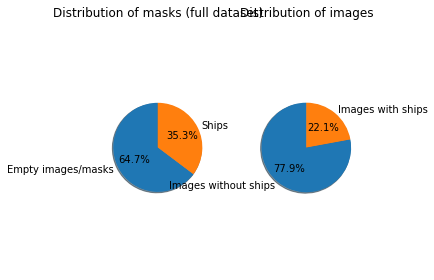

In [9]:
# Number of masks - Size of the total dataset
n_masks = len(masks.index)
print("Total number of masks (full dataset size = ships + images without ships):\t", n_masks)

# Number of empty masks - Number of empty images
n_empty_masks = len(masks[masks['EncodedPixels'].isnull()].index)
print(" ↳Number of images without ships (number of empty masks):\t\t\t", n_empty_masks)

# Number of not empty masks - Number of ships
n_ships = masks.count()['EncodedPixels']
print(" ↳Total number of ships (number of non-empty masks):\t\t\t\t", n_ships)

# Number of images
n_images = masks.nunique()['ImageId']
print("\nNumber of images:\t\t\t\t\t\t\t\t", n_images)

# Number of images without ships (number of empty masks)
n_im_wo_ship = masks[masks['EncodedPixels'].isnull()].nunique()['ImageId']
print(" ↳Number of images without ships (number of empty masks):\t\t\t",n_im_wo_ship)

# Number of images containing a ship
n_im_with_ship = masks[~masks['EncodedPixels'].isnull()].nunique()['ImageId']
print(" ↳Number of images containing a ship:\t\t\t\t\t\t", n_im_with_ship)

#Number of images containing multiple ships
n_im_multi_ship = masks[masks['ImageId'].duplicated()].nunique()['ImageId']
print("   ↳Number of images containing multiple ships:\t\t\t\t\t", n_im_multi_ship)

# Pie chart
labels = ['Empty images/masks', 'Ships']
sizes = [n_empty_masks, n_ships]
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Distribution of masks (full dataset)')
plt.tight_layout()

#Distribution of images
labels = ['Images without ships', 'Images with ships']
sizes = [n_im_wo_ship, n_im_with_ship]
plt.subplot(1,2,2)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.title('Distribution of images')
plt.tight_layout()

plt.subplots_adjust( wspace=0.5)

Note: The two pie charts are different because images can contain multiple ships.

# Distribution of the number of ships per image

Number of ships per image:
count    192556.000000
mean          0.424412
std           1.199094
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: EncodedPixels, dtype: float64

Histogram of number of ships per image
+---------------------------+--------+
| Number of ships per image | Count  |
+---------------------------+--------+
|            0.0            | 150000 |
|            1.0            | 27104  |
|            2.0            |  7674  |
|            3.0            |  2954  |
|            4.0            |  1622  |
|            5.0            |  925   |
|            6.0            |  657   |
|            7.0            |  406   |
|            8.0            |  318   |
|            9.0            |  243   |
|            10.0           |  168   |
|            11.0           |  144   |
|            12.0           |  124   |
|            13.0           |   75   |
|            14.0           |   76   |
|          

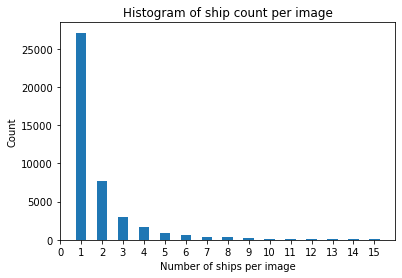

In [10]:
ship_per_img = masks.groupby('ImageId').count().iloc[:,0]
print("Number of ships per image:")
print(ship_per_img.describe())

print("\nHistogram of number of ships per image")
[count, bins] = np.histogram(ship_per_img,bins=ship_per_img.max()+1,range=(0,ship_per_img.max()+1))
x = PrettyTable()
x.add_column("Number of ships per image",bins[:-1])
x.add_column("Count", count)
print(x)

plt.hist(ship_per_img,bins=ship_per_img.max(),range=(1,ship_per_img.max()+1),rwidth=0.5, align='left');
plt.xticks(np.arange(ship_per_img.min(), ship_per_img.max()+1, step=1));
plt.xlabel("Number of ships per image");
plt.ylabel("Count");
plt.title("Histogram of ship count per image");

Note: for better visiblity we removed the count of images whithout a ship from the histogram.
Conclusion: most of the images with ships contain only a few ships

# Distribution of the size of the ships

In [11]:
def rle_decode(mask_rle, shape=(768, 768)):
    """
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - ship 0 - background
    If mask_rle mask is nan, the returned numpy array only contains zeros
    """
    # Create the all zero mask
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    if mask_rle == mask_rle: # if mask_rle is nan that this equality check returns false and the mask array remains 0
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths

        for lo, hi in zip(starts, ends):
            mask[lo:hi] = 1
        
    return mask.reshape(shape).T  # Needed to align to RLE direction

In [13]:
# calculate ship-noship ratio for each mask and sum for each mask
ShipSize = np.zeros(len(masks.index))
pbar = tqdm_notebook(total=len(masks.index))
for index, row in masks.iterrows():
    mask = row['EncodedPixels']
    if mask == mask: #If mask is nan, mask == mask is returns false
        ShipSize[index] = np.sum(rle_decode(mask))/(768*768)
    pbar.update(1)
pbar.close()

pd.Series(ShipSize*100).describe()

/var/folders/c6/_zhl81td4_7dslytk2yh2p6c0000gn/T/ipykernel_60885/2825742791.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(total=len(masks.index))


  0%|          | 0/231723 [00:00<?, ?it/s]

count    231723.000000
mean          0.093720
std           0.313059
min           0.000000
25%           0.000000
50%           0.000000
75%           0.022464
max           4.391819
dtype: float64

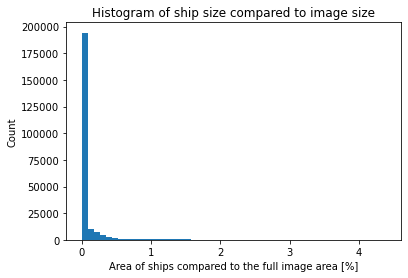

In [14]:
plt.hist(ShipSize*100,bins=50);
plt.xlabel("Area of ships compared to the full image area [%]");
plt.ylabel("Count");
plt.title("Histogram of ship size compared to image size");

Conclusion: Most of the ships are very small, smaller that 0.1% of an image.

# Example data

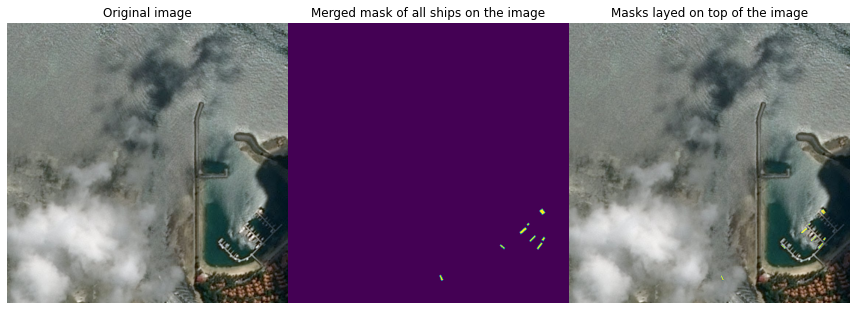

In [15]:
#Displays the image, the mask and both
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
cmap = pl.cm.viridis
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

img = imread(ship_dir + '/train_v2/' + 'ff83ead39.jpg')
img_masks = masks.loc[masks['ImageId'] == 'ff83ead39.jpg', 'EncodedPixels'].tolist()

all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(12, 30))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.75, cmap=my_cmap)
axarr[0].set_title("Original image")
axarr[1].set_title("Merged mask of all ships on the image")
axarr[2].set_title("Masks layed on top of the image")
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

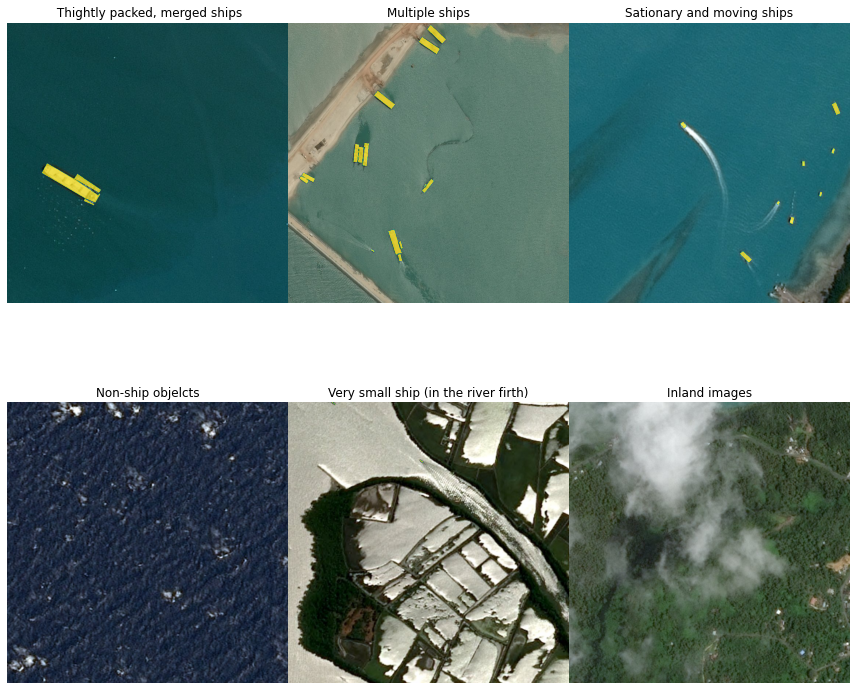

In [17]:
def load_and_disp_image_with_map(ImageId,im_title="",ax=plt):
    img = imread(ship_dir + '/train_v2/' + ImageId)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)
    
    ax.imshow(img)
    ax.imshow(all_masks, alpha=0.75, cmap=my_cmap)
    ax.axis('off')
    ax.set_title(im_title)


fig, axarr = plt.subplots(2, 3, figsize=(12,12))
load_and_disp_image_with_map('0a0df8299.jpg',im_title=" Thightly packed, merged ships", ax = axarr[0,0])
load_and_disp_image_with_map('0a1a7f395.jpg',im_title="Multiple ships", ax = axarr[0,1])
load_and_disp_image_with_map('0a2e15e29.jpg',im_title="Sationary and moving ships", ax = axarr[0,2])
load_and_disp_image_with_map('0a2f58d54.jpg',im_title="Non-ship objelcts", ax = axarr[1,0])
load_and_disp_image_with_map('0a4ad0982.jpg',im_title="Very small ship (in the river firth)", ax = axarr[1,1])
load_and_disp_image_with_map('0a3ab4644.jpg',im_title="Inland images",ax = axarr[1,2])

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()